In [1]:
%run ../setup_notebook.ipynb

In [2]:
# notebook specific imports
import pickle
import time
import utils.utils_funcs as utils
from matplotlib.widgets import Lasso
from matplotlib.collections import RegularPolyCollection
from matplotlib import colors as mcolors, path
from utils.paq2py import paq_read
from utils.rsync_aligner import Rsync_aligner
from utils.data_import import Session
from subsets_analysis import Subsets


In [3]:
with open('/home/jamesrowland/Documents/Code/Vape/run_pkls/RL048/run24.pkl', 'rb') as f:
    run = pickle.load(f)

In [4]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames'])

In [5]:
run.session.__dict__.keys()

dict_keys(['file_name', 'experiment_name', 'task_name', 'subject_ID', 'datetime', 'datetime_string', 'events', 'times', 'print_lines'])

In [6]:
figure_path = '/home/jamesrowland/Documents/Code/Vape/figures/s1s2_imaging_subsets_prototype'

In [7]:
# correct_s2p_combined(run.s2p_path)
# combined_path = os.path.join(run.s2p_path, 'combined')
# combined_path = '/home/jamesrowland/Documents/packerstation/jrowland/'\
#                 'Data/2019-07-09/2019-07-09_J048_t-003/suite2p/combined'

combined_path = '/home/jamesrowland/Documents/packerstation/jrowland/Data/'\
                '2019-08-03/2019-08-03_RL048_t-004/suite2p/combined'

In [8]:
flu, spks, stat = utils.s2p_loader(combined_path, subtract_neuropil=True)
flu = utils.dfof2(flu)
flu.shape

Loading 6394 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7


(6394, 17958)

In [9]:
n_planes = 3 # remove two cells below if just single plane
assert flu.shape[1]*n_planes - n_planes <=  sum(run.num_frames) <= flu.shape[1] * n_planes + n_planes

In [10]:
plane0 = []
for i,s in enumerate(stat):
    if s['iplane'] == 0:
        plane0.append(i)     

In [11]:
# just take the first plane
flu = flu[plane0,:]
stat = stat[plane0]
flu.shape

(2056, 17958)

In [12]:
meds = []
for i,s in enumerate(stat):
    meds.append(s['med'][1])
  

max(meds)

1019.0

In [13]:
s2_only = False

s2_cells = []
for i,s in enumerate(stat):
    if s['med'][1] > 684:
        s2_cells.append(i)
        
if s2_only:
    flu = flu[s2_cells,:]
    stat = stat[s2_cells]
    
flu.shape       

(2056, 17958)

In [14]:
# the lengths of the actual tseries
tseries_lens = run.num_frames
tseries_lens

[7785, 7620, 13548, 13548, 11371]

In [15]:
# get the frames that actually correspond to analysed tseries
paqio_frames = utils.tseries_finder(tseries_lens, run.frame_clock)

In [16]:
frames_ms = run.aligner.B_to_A(paqio_frames)
frames_ms = frames_ms[::3]  # just do the first plane for now

## make the frame clock and the fluoresence matrix the same length
# these prints should be the same
print(len(frames_ms))
# subtraction necessary for RL048 run24 as last tseries wasn't fully paqed
print(flu.shape[1] - tseries_lens[-1] / n_planes)  

flu = flu[:, range(len(frames_ms))]
flu.shape                             

14167
14167.666666666666


(2056, 14167)

In [17]:
assert len(run.trial_start) == len(run.trial_type) == len(run.outcome)
num_trials = len(run.trial_start)

In [18]:
pre_frames = 10
post_frames = 20

trial_flu, imaging_trial = utils.flu_splitter(flu, frames_ms, run.trial_start, pre_frames, post_frames)

In [19]:
outcome = run.outcome[imaging_trial]
len(outcome)

155

In [20]:
trial_flu.shape

(2056, 30, 155)

In [21]:
hit_flu = trial_flu[:,:,np.where(outcome=='hit')[0]]
hit_flu.shape

(2056, 30, 58)

In [22]:
miss_flu = trial_flu[:,:,np.where(outcome=='miss')[0]]
miss_flu.shape

(2056, 30, 46)

In [23]:
fp_flu = trial_flu[:,:,np.where(outcome=='fp')[0]]
fp_flu.shape

(2056, 30, 5)

In [24]:
cr_flu = trial_flu[:,:,np.where(outcome=='cr')[0]]
cr_flu.shape

(2056, 30, 46)

In [25]:
grand_hit = np.mean(np.mean(hit_flu,0),1)
grand_miss = np.mean(np.mean(miss_flu,0),1)
grand_fp = np.mean(np.mean(fp_flu,0),1)
grand_cr = np.mean(np.mean(cr_flu,0),1)

pre_stim = range(3,7)
post_stim = range(14,19)
len(post_stim)

5

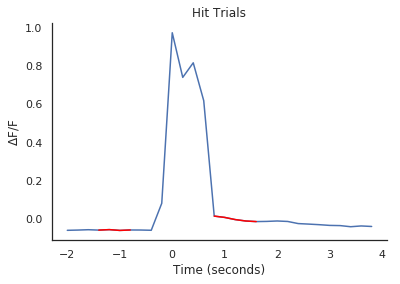

In [26]:
frame_rate = 5

x_axis = (np.arange(len(grand_hit)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_hit)
plt.plot(x_axis[pre_stim], grand_hit[pre_stim], color='red')
plt.plot(x_axis[post_stim], grand_hit[post_stim], color='red')
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Hit Trials')
plt.savefig(os.path.join(figure_path, 'grand_hit_sta.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_hit_sta.pdf'), bbox_inches="tight")


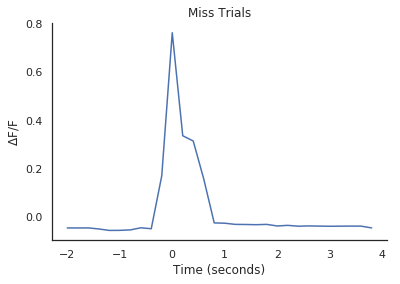

In [27]:
x_axis = (np.arange(len(grand_miss)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_miss)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Miss Trials')
plt.savefig(os.path.join(figure_path, 'grand_miss.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_miss.pdf'), bbox_inches="tight")

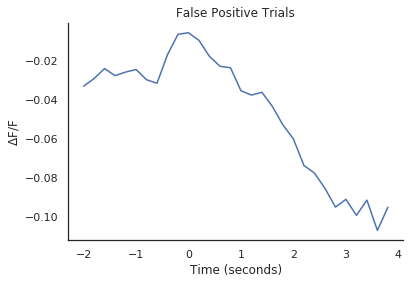

In [28]:
x_axis = (np.arange(len(grand_fp)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_fp)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('False Positive Trials')
plt.savefig(os.path.join(figure_path, 'grand_fp.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_fp.pdf'), bbox_inches="tight")

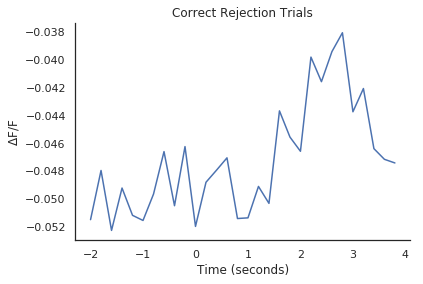

In [29]:
x_axis = (np.arange(len(grand_cr)) - pre_frames) / frame_rate
plt.plot(x_axis, grand_cr)
sns.despine()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Time (seconds)')
plt.title('Correct Rejection Trials')
plt.savefig(os.path.join(figure_path, 'grand_cr.png'), bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'grand_cr.pdf'), bbox_inches="tight")

In [30]:
sta_hit = np.mean(grand_hit[post_stim]) - np.mean(grand_hit[pre_stim])
sta_hit

0.057027955

In [31]:
sta_miss = np.mean(grand_miss[post_stim]) - np.mean(grand_miss[pre_stim])
sta_miss

0.024766143

In [32]:
subsets = Subsets(run)
subsets.__dict__.keys()

dict_keys(['trial_info', 'outcome', 'go_outcome', 'nogo_outcome', 'trial_subsets', 'subset_sizes'])

In [33]:
subsets.subset_sizes

array([  5,  10,  20,  30,  40,  50, 150])

In [34]:
# from subsets_analysis import analyse_subsets, subset_attr
# mouse_id = 'RL048'
# run_numbers = [24]
# subsets, run = analyse_subsets(mouse_id, run_numbers)
# trial_subsets = subsets.get_full_list()
# trial_subsets = trial_subsets[imaging_trial]

In [35]:
intersect = lambda A, B: set(A) - (set(A) - set(B))

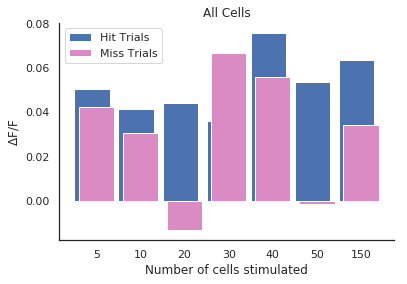

In [36]:
plt.figure()

hit_arrs = []
miss_arrs = []

for i,sub_size in enumerate(subsets.subset_sizes):

    hit_idx = intersect(np.where(subsets.trial_subsets==sub_size)[0], np.where(outcome=='hit')[0])
    miss_idx = intersect(np.where(subsets.trial_subsets==sub_size)[0], np.where(outcome=='miss')[0])

    hit = trial_flu[:,:,list(hit_idx)]
    miss = trial_flu[:,:,list(miss_idx)]
    
    hit_arrs.append(hit)
    miss_arrs.append(miss)

    grand_hit = np.mean(np.mean(hit, 0), 1)
    grand_miss = np.mean(np.mean(miss, 0), 1)

    sta_hit = np.mean(grand_hit[post_stim]) - np.mean(grand_hit[pre_stim])
    sta_miss = np.mean(grand_miss[post_stim]) - np.mean(grand_miss[pre_stim])
  

    if i == 0:
        plt.bar(i-0.1, sta_hit, color=sns.color_palette()[0], label='Hit Trials')
        plt.bar(i, sta_miss, color=sns.color_palette()[6], label='Miss Trials')
    else:
        plt.bar(i-0.1, sta_hit, color=sns.color_palette()[0])
        plt.bar(i, sta_miss, color=sns.color_palette()[6])
                
    plt.legend()
    plt.ylabel(r'$\Delta $F/F')
    plt.xlabel('Number of cells stimulated')
    sns.despine()
    

plt.xticks(range(len(subsets.subset_sizes)), subsets.subset_sizes)

plt.title('All Cells')

plt.savefig(os.path.join(figure_path, 'all_cells.pdf'))
plt.savefig(os.path.join(figure_path, 'all_cells.png'))

In [37]:
# balance the number of hit and miss trials

hits = []
misses = []

hit_mean = []
miss_mean = []

for i, sub_size in enumerate(subsets.subset_sizes):
    
    hit_arr = hit_arrs[i]
    miss_arr = miss_arrs[i]

    num_hits = hit_arr.shape[2]
    num_miss = miss_arr.shape[2]     
    balanced = (num_hits if num_hits < num_miss else num_miss) 

    post_hit = hit_arr[:,post_stim,:]
    post_hit = post_hit[:,:,range(balanced)]
    [hits.append(f) for f in post_hit.ravel()]
    [hit_mean.append(f) for f in np.mean(post_hit,0).ravel()]
    
    
    post_miss = miss_arr[:,post_stim,:]
    post_miss = post_miss[:,:,range(balanced)]
    [misses.append(f) for f in post_miss.ravel()]
    [miss_mean.append(f) for f in np.mean(post_miss,0).ravel()]
    


In [38]:
lick_flu = np.load('/home/jamesrowland/Documents/Code/Vape/lick_flu.npy')
spont_flu =  np.load('/home/jamesrowland/Documents/Code/Vape/spont_flu.npy')

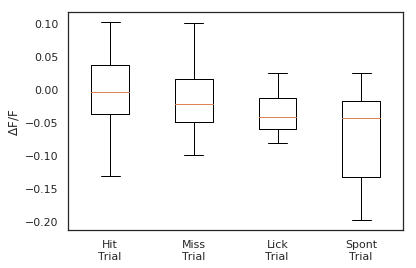

In [39]:
b = plt.boxplot([hit_mean, miss_mean, lick_flu, spont_flu], positions=[1,2,3,4],
                labels=['Hit\nTrial', 'Miss\nTrial', 'Lick\nTrial', 'Spont\nTrial'],
                showfliers=False)

l = plt.ylabel(r'$\Delta $F/F')
plt.savefig(os.path.join(figure_path, 'all_boxes.png'), bbox_inches='tight')

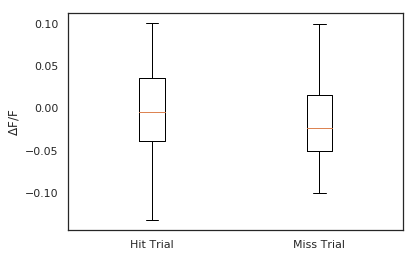

In [40]:
b = plt.boxplot([hit_mean, miss_mean],
                labels=['Hit Trial', 'Miss Trial'],
                showfliers=False)

l = plt.ylabel(r'$\Delta $F/F')
plt.savefig(os.path.join(figure_path, 'hit_miss_box.png'), bbox_inches='tight')

In [41]:
np.mean(misses)

-0.021402134

In [42]:
# class Datum(object):
# #     colorin = mcolors.to_rgba("red")
# #     colorout = mcolors.to_rgba("blue")

# #     def __init__(self, x, y, include=False):
# #         self.x = x
# #         self.y = y
# #         if include:
# #             self.color = self.colorin
# #         else:
# #             self.color = self.colorout


# # class LassoManager(object):
# #     def __init__(self, ax, data):
# #         self.axes = ax
# #         self.canvas = ax.figure.canvas
# #         self.data = data

# #         self.Nxy = len(data)

# #         facecolors = [d.color for d in data]
# #         self.xys = [(d.x, d.y) for d in data]
# #         self.collection = RegularPolyCollection(4, sizes=(100,),
# #                                                 facecolors=facecolors,
# #                                                 offsets=self.xys,
# #                                                 transOffset=ax.transData,
# #                                                 alpha =0.01)
# #         ax.add_collection(self.collection)

# #         self.cid = self.canvas.mpl_connect('button_press_event', self.onpress)

# #     def callback(self, verts):
# #         facecolors = self.collection.get_facecolors()
# #         p = path.Path(verts)
# #         # True if point selected else false 
# #         self.ind = p.contains_points(self.xys)
# #         for i in range(len(self.xys)):
# #             if self.ind[i]:
# #                 facecolors[i] = Datum.colorin
# #             else:
# #                 facecolors[i] = Datum.colorout

# #         self.canvas.draw_idle()
# #         self.canvas.widgetlock.release(self.lasso)
# #         del self.lasso

# #     def onpress(self, event):

# #         if self.canvas.widgetlock.locked():
# #             return
# #         if event.inaxes is None:
# #             return
# #         self.lasso = Lasso(event.inaxes,
# #                            (event.xdata, event.ydata),
# #                            self.callback)
# #         # acquire a lock on the widget drawing
# #         self.canvas.widgetlock(self.lasso)


# # axis_edge = 2*min(paqio_frames) 
# # data = [Datum(*xy) for xy in np.transpose(np.vstack((paqio_frames, np.ones(len(paqio_frames)))))]
# # ax = plt.axes(xlim=(min(paqio_frames)-axis_edge, max(paqio_frames)+axis_edge), ylim=(0, 2), autoscale_on=False)
# # ax.set_title('Lasso points using left mouse button')

# # lman = LassoManager(ax, data)
# # plt.show()